# Table Extraction Case Study
### AAIC Self Case Study II
### Author: Soumya De

<hr>

## 6. Post training quantization using tflite

In the previous section we had obtained the best model and had saved it in the disk. Now we will load the saved model and try to compress the model using tflite. 


In [1]:
# importing dependencies
import os
import re
import numpy as np
import csv
import pandas as pd
from tqdm import tqdm
from PIL import Image
import cv2
from time import strftime
import pytesseract
import tensorflow as tf
from tensorflow.keras import Model

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
#loading the best_model
model_path = 'final_model'
model = tf.keras.models.load_model(model_path)

In [4]:
# saving it as single .h5 file to compare size before and after compression
final_model_h5 = os.path.sep.join(['final_model', 'tablenet_densenet121.h5'])
if not os.path.exists(final_model_h5):
    model.save(final_model_h5)

In [5]:
# getting size before applying quantization
filesize = round(os.path.getsize(final_model_h5)/(1024*1024),2)
print('The size of .h5 model file : {} MB'.format(filesize))

The size of .h5 model file : 34.26 MB


In [6]:
# converting to tflite using TFLiteConverter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\soumy\AppData\Local\Temp\tmpzkdwks2f\assets
INFO:tensorflow:Assets written to: C:\Users\soumy\AppData\Local\Temp\tmpzkdwks2f\assets


In [8]:
final_model_tf_lite = os.path.sep.join(['final_model', 'tablenet_densenet121_lite.tflite'])
with open(final_model_tf_lite, 'wb') as f:
    f.write(tflite_model)

In [9]:
# getting size after applying quantization
filesize = round(os.path.getsize(final_model_tf_lite)/(1024*1024),2)
print('The size of tflite model file : {} MB'.format(filesize))

The size of tflite model file : 8.8 MB


In [10]:
# checking input tensor shape
interpreter = tf.lite.Interpreter(model_path=final_model_tf_lite)
ip_d = interpreter.get_input_details()[0]
op_d = interpreter.get_output_details()[0]

print('Input shape : {}'.format(ip_d['shape']))
print('Output shape : {}'.format(op_d['shape']))

Input shape : [  1 512 512   3]
Output shape : [  1 512 512   3]


### Inference using tflite model

In [11]:
# getting predictions with the tflite model
img_path = os.path.join('data', 'ICDAR 2017', 'table_images', 'POD_1066.png')
image_orig = Image.open(img_path)
original_dim = image_orig.size
image = image_orig.resize((512,512))
np_image = np.asarray(image)/255.0
np_image = np_image.astype(np.float32)
np_image = np.expand_dims(np_image, axis=0)

In [12]:
interpreter.allocate_tensors()
interpreter.set_tensor(ip_d['index'], np_image)
interpreter.invoke()
preds = interpreter.get_tensor(op_d['index'])

In [13]:
def render(mask):
  mask = tf.argmax(mask, axis=-1)
  mask = mask[..., tf.newaxis]
  return mask[0]

In [28]:
tab_mask = np.squeeze(render(preds).numpy())
tab_mask = Image.fromarray(np.uint8(tab_mask))
tab_mask = tab_mask.resize(original_dim)
tab_mask = np.array(tab_mask)

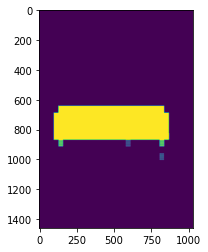

In [29]:
# visualizing sample mask
import matplotlib.pyplot as plt
plt.imshow(tab_mask)